### Exploratory Data Analysis(EDA)

_Pavan Akula, September 15, 2018_

The goal of this assignment is build a data pipeline in Python that downloads _Titanic_ data from _Kaggle_ website, trains a classification model using sklearn and score the model on the test dataset.

Following steps are used to building the data pipeline. This notebook will focus mainly data imputation and model selection.

1. Install Python and required libraries using Anaconda framework
2. Download data from _Kaggle_ website
3. Run statistical summeries and impute missing values
4. Use visualzations to see spread of data in various categories
5. Build a predictive model using _sklearn_ library
6. Apply the model to test data to score it

#### Dataset

Dataset is downloaded from [Kaggle](https://www.kaggle.com/c/titanic/data), I will be using _train.csv_ to train the predictive model and _test.csv_ to score it. Since, _kaggle_ needs user name and password to download data, I have manually downloaded and uploaded to public repository on _Github_. For the scope of this analysis, I will be downloading the files from [Github](www.github.com/akulapa) and perform steps three through five.

In [1]:
#Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
#Load dataset
train = pd.read_csv('https://raw.githubusercontent.com/akulapa/Data622-HW2/master/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/akulapa/Data622-HW2/master/test.csv')

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Training dataset has 

- PassengerId, it is running integer value to identify each passenger
- Survived, column contains binary value _0 or 1_, indicating if passenger survived in tragic Titanic accident
- Pclass, this is a categorical column with values _1, 2, and 3_, indicating passenger accomidation class
- Name, passenger name, it is combination of last name, prefix and first name
- Sex, gender of the passenger
- Age, age of the passenger, it is given as decimal
- SibSp, siblings and spouses traveling with the passenger
- Parch, number of parents and children traveling with the passenger
- Ticket, ticket numbers
- Cabin, cabin allocated to the passenger
- Embarked, port for which passenger boarded the ship, C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Test dataset has same columns as training dataset, excepct it does not have _Survived_ column.

#### Variable Evaluation

Let see if all the variables has data and how it can be used to build the model. Idea is to convert all the variables into numeric equivalent where possible. Cases where variable is not possible to convert into numeric, we should be able to convert them into categorical values.

Starting with variable _Name_ is in _lastname_, _prefix_ and _firstname_ format. It also has additional information next to _firstname_ within parentisis. Complete name may not be useful in model building. Hence, we will extract _prefix_ and store into new variable _Title_ that could be more useful in building predictive model.

In [7]:
#Wikipedia suggests "Jonkheer" and "Countess" is honorific titile
#https://en.wikipedia.org/wiki/Jonkheer
#https://en.wikipedia.org/wiki/Count
#Create dictionary and map them more generic values

Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

#Split name as comma seperated values and get second value(1) from the list
#Split the value again based on seperator(.), get first value(0)
#ultimately get prefix value

train['Title'] = train['Name'].map(lambda Name:Name.split(',')[1].split('.')[0].strip())
train['Title'] = train.Title.map(Title_Dictionary)

#Get top 5 observations
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Now, lets focus on variable _Cabin_, upon investigation first letter in the values denote deck that was assigned to passenger. I believe deck would be more useful to predicting passenger survival.

In [8]:
#Extract first letter from Cabin value, store it into new column 'Deck'

train['Deck'] = train.Cabin.str[0]
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN


Next in the variable sequence is _Ticket_, it is given as an alpha-numeric value. Intuitively, a numeric part of the value could be more useful in building a predictive model.

In [9]:
"""
The function will process variable Ticket
It will extract the numeric value
One advantage of writing function after initiating is variables is they can be called using global and manipulate them
"""

def process_ticket():
    
    #Refer the dataset using global
    global train
    
    # a function that extracts numeric value from the ticket, returns 'Unk' if no numeric postfix
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = filter(lambda t : t.isdigit(), ticket)
        ticket = ''.join(ticket)
        if len(ticket) > 0:
            return ticket
        else: 
            return np.nan
    
    # map cleanTicket function and extract the value for each row:
    train['TicketNumber'] = train['Ticket'].map(cleanTicket)
    return train

#Call the function and store the results
train = process_ticket()

#Get top 5 observations
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,TicketNumber
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,21171
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,17599
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,3101282
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,113803
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,373450


Variables _SibSp_ and _Parch_ could be used to derive total members in a passengers family. Ultimately, deriving the size of the family.

In [10]:
#Get number of members in the family
train['FamilyMembers'] = train['Parch'] + train['SibSp']

#Get family size
train['Family'] = (train['FamilyMembers']).map(lambda s: 'Single' if s <= 1 else 'Small' if s >= 2 and s < 5 else 'Large' if s >= 5 else 'Unknown')

#Get top 5 observations
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,TicketNumber,FamilyMembers,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,21171,1,Single
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,C,17599,1,Single
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,3101282,0,Single
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,C,113803,1,Single
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,373450,0,Single


Finally, we have a dataset where every variable is either numeric or categorical. Now we can drop variables _Name_, _Cabin_, _Ticket_ and _Family_.

In [11]:
#Drop the variables
train.drop('Name', inplace=True, axis=1)
train.drop('Ticket', inplace=True, axis=1)
train.drop('Cabin', inplace=True, axis=1)
train.drop('FamilyMembers', inplace=True, axis=1)

#As passengerId is not contributing any information it can be dropped
train.drop('PassengerId', inplace=True, axis=1)

#Get top 5 observations
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
0,0,3,male,22.0,1,0,7.2500,S,Mr,NaN,21171,Single
1,1,1,female,38.0,1,0,71.2833,C,Mrs,C,17599,Single
2,1,3,female,26.0,0,0,7.9250,S,Miss,NaN,3101282,Single
3,1,1,female,35.0,1,0,53.1000,S,Mrs,C,113803,Single
4,0,3,male,35.0,0,0,8.0500,S,Mr,NaN,373450,Single


#### Variable Imputation

Lets see variable with missing values.

In [12]:
#Describe gives statistical information about numerical columns in the dataset
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
#Columns with null values
train.isnull().sum()

Survived          0
Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Fare              0
Embarked          2
Title             0
Deck            687
TicketNumber      4
Family            0
dtype: int64

Text(0.5,1,'Variables with missing values')

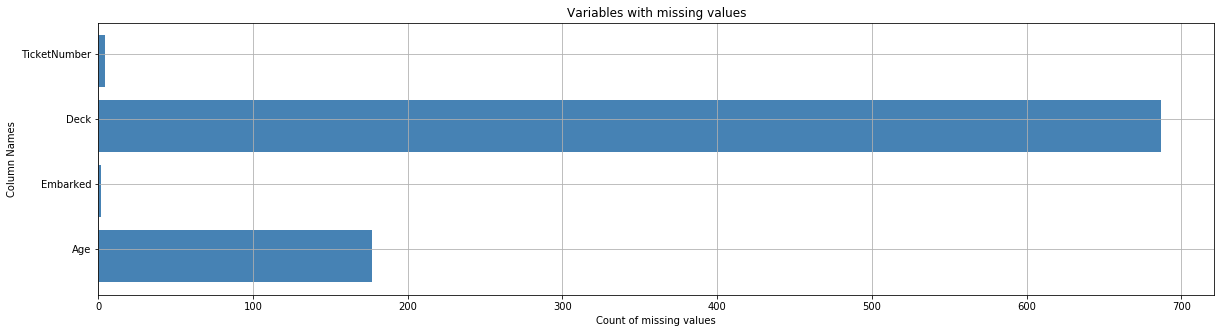

In [14]:
#Get null columns
null_columns=train.columns[train.isnull().any()]

#Graphical representation
labels = []
values = []
for col in null_columns:
    labels.append(col)
    values.append(train[col].isnull().sum())
ind = np.arange(len(labels))
width=0.6
fig, ax = plt.subplots(figsize=(20,5))
ax.grid()
rects = ax.barh(ind, np.array(values), color='steelblue')
ax.set_yticks(ind+((width)/5.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_ylabel("Column Names")
ax.set_title("Variables with missing values")

There are four variables, _Age_, _Embarked_, _Deck_ and _TicketNumber_ with missing values. 


Starting with _Embarked_ let's impute one variable at a time. Possible values for _Embarked_ are C = Cherbourg, Q = Queenstown, S = Southampton.

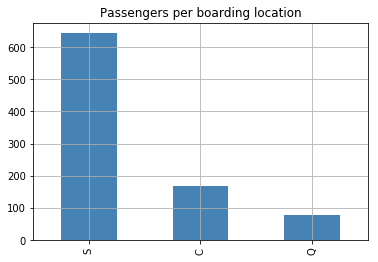

In [15]:
train.Embarked.value_counts().plot(kind='bar', color='steelblue', grid=True)
plt.title("Passengers per boarding location");

In [16]:
#Get average price per port
train.groupby('Embarked').agg('mean')['Fare']

Embarked
C    59.954144
Q    13.276030
S    27.079812
Name: Fare, dtype: float64

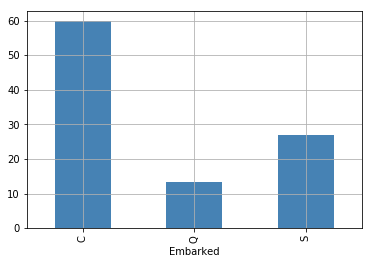

In [17]:
#Graphical presentation
train.groupby('Embarked').agg('mean')['Fare'].plot(kind='bar', color='steelblue', grid=True);

In [18]:
df = train.groupby(['Embarked', 'Sex']).size().sort_values(ascending=False).reset_index(name='count')
df

,Embarked,Sex,count
0,S,male,441
1,S,female,203
2,C,male,95
3,C,female,73
4,Q,male,41
5,Q,female,36


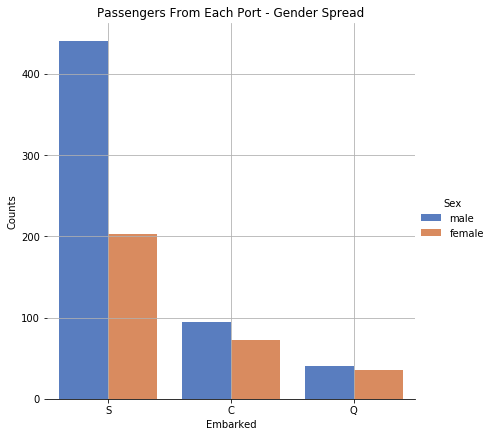

In [19]:
# Passengers From Each Port - Gender Spread
g = sns.catplot(x="Embarked", y="count", hue="Sex", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Passengers From Each Port - Gender Spread", fontsize=12);
plt.grid(True)

In [20]:
#Null value rows for Embarked column
train[train['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
61,1,1,female,38.0,0,0,80.0,NaN,Miss,B,113572,Single
829,1,1,female,62.0,0,0,80.0,NaN,Mrs,B,113572,Single


Average _Fare_ matches _Fare_ paid by passengers boarding from port _Cherbourg_. Looking at average price and spread of gender boarding from _Cherbourg_ port we can manually update missing _Embarked_ value to C. 

In [21]:
#Update missing value with 'C'
train['Embarked'] = train['Embarked'].fillna('C')

#Check for missing values - No issing values are found
train[train['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family


In [22]:
#Null value rows for TicketNumber column
train[train['TicketNumber'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
179,0,3,male,36.0,0,0,0.0,S,Mr,NaN,NaN,Single
271,1,3,male,25.0,0,0,0.0,S,Mr,NaN,NaN,Single
302,0,3,male,19.0,0,0,0.0,S,Mr,NaN,NaN,Single
597,0,3,male,49.0,0,0,0.0,S,Mr,NaN,NaN,Single


Missing value for the _TicketNumber_ could be updated by median value because it almost random number given assigned to a passenger.

In [23]:
#Get median value
ticketMedian = train[train['TicketNumber'].notnull()].TicketNumber.median()

#Replace missing ticketNumber by median values
train['TicketNumber'] = train['TicketNumber'].fillna(int(ticketMedian))

#Null value rows for Embarked column
train[train['TicketNumber'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family


In [24]:
train['Fare'].groupby(train['Deck']).mean()

Deck
A     39.623887
B    113.505764
C    100.151341
D     57.244576
E     46.026694
F     18.696792
G     13.581250
T     35.500000
Name: Fare, dtype: float64

In [25]:
#Null value rows for Deck column
train[train['Deck'].isnull()].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
0,0,3,male,22.0,1,0,7.2500,S,Mr,NaN,21171,Single
2,1,3,female,26.0,0,0,7.9250,S,Miss,NaN,3101282,Single
4,0,3,male,35.0,0,0,8.0500,S,Mr,NaN,373450,Single
5,0,3,male,NaN,0,0,8.4583,Q,Mr,NaN,330877,Single
7,0,3,male,2.0,3,1,21.0750,S,Master,NaN,349909,Small
8,1,3,female,27.0,0,2,11.1333,S,Mrs,NaN,347742,Small
9,1,2,female,14.0,1,0,30.0708,C,Mrs,NaN,237736,Single
12,0,3,male,20.0,0,0,8.0500,S,Mr,NaN,2151,Single
13,0,3,male,39.0,1,5,31.2750,S,Mr,NaN,347082,Large
14,0,3,female,14.0,0,0,7.8542,S,Miss,NaN,350406,Single


In [26]:
#Null value rows for Deck column
train[train['Deck']=='A'].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
23,1,1,male,28.0,0,0,35.5000,S,Mr,A,113788,Single
96,0,1,male,71.0,0,0,34.6542,C,Mr,A,17754,Single
174,0,1,male,56.0,0,0,30.6958,C,Mr,A,17764,Single
185,0,1,male,NaN,0,0,50.0000,S,Mr,A,113767,Single
209,1,1,male,40.0,0,0,31.0000,C,Mr,A,112277,Single
284,0,1,male,NaN,0,0,26.0000,S,Mr,A,113056,Single
445,1,1,male,4.0,0,2,81.8583,S,Master,A,33638,Small
475,0,1,male,NaN,0,0,52.0000,S,Mr,A,110465,Single
556,1,1,female,48.0,1,0,39.6000,C,Royalty,A,11755,Single
583,0,1,male,36.0,0,0,40.1250,C,Mr,A,13049,Single


In [27]:
#Null value rows for Deck column
train[train['Deck']=='B'].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
31,1,1,female,NaN,1,0,146.5208,C,Mrs,B,17569,Single
54,0,1,male,65.0,0,1,61.9792,C,Mr,B,113509,Single
61,1,1,female,38.0,0,0,80.0000,C,Miss,B,113572,Single
118,0,1,male,24.0,0,1,247.5208,C,Mr,B,17558,Single
139,0,1,male,24.0,0,0,79.2000,C,Mr,B,17593,Single
170,0,1,male,61.0,0,0,33.5000,S,Mr,B,111240,Single
194,1,1,female,44.0,0,0,27.7208,C,Mrs,B,17610,Single
195,1,1,female,58.0,0,0,146.5208,C,Miss,B,17569,Single
257,1,1,female,30.0,0,0,86.5000,S,Miss,B,110152,Single
263,0,1,male,40.0,0,0,0.0000,S,Mr,B,112059,Single


Since ticket _Fare_ increase or decrease is not consistent among the deck's and there are some cases in _Deck - B_, single passenger paid a very high price. It is safe to conclude that missing _Deck_ values can be classified into there own group. Let's replace missing _Deck_ with value 'U'.

In [28]:
#Replace missing Deck values with 'U'
train['Deck'] = train['Deck'].fillna('U')

#Null value rows for Deck column
train[train['Deck'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family


Finally, variable _Age_ has 177 observations with missing values. Since missing values for all other variables are imputed, let's use _RandomForestRegressor_ to find missing values. To run random forest regression on the data, we need to convert variables to numeric or categorical variables. Let's convert variables into numeric values.

In [29]:
#Convert string values to numeric values
train['Sex'] = train['Sex'].map({'female':0, 'male':1})
train['Family'] = train['Family'].map({'Single':0, 'Small':1, 'Large':2})
train['Title'] = train['Title'].map({'Mrs':0, 'Miss':1, 'Mr':2, 'Master':3, 'Officer':4, 'Royalty':5})
train['Embarked'] = train['Embarked'].map({'C':0, 'Q':1, 'S':2})
train['Deck'] = train['Deck'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7, 'U':8})

#Convert variables into categories
train['Sex'] = train['Sex'].astype('category')
train['Family'] = train['Family'].astype('category')
train['Title'] = train['Title'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
train['Deck'] = train['Deck'].astype('category')
train['Survived'] = train['Survived'].astype('category')
train['Pclass'] = train['Pclass'].astype('category')

In [30]:
#Function to calculate missing values for age
def process_missing_age():
    
    global train
    
    #Get observations with non NA values for Age
    train_age = train.loc[(train.Age.notnull())]
    
    #Get observations with NA values for Age
    test_age = train.loc[(train.Age.isnull())]
    
    #Seperate X and y values for training dataset
    X_train = train_age.drop('Age', axis=1).values
    y_train = train_age['Age'].values
    
    #As we will imputing missing Age values, drop the column from test dataset
    X_test = test_age.drop('Age', axis=1).values
    
    #Lets use all parameters as default, with number trees as 500 in random forest regressor
    ramdomForest = RandomForestRegressor(n_estimators=500, n_jobs=-1)
    ramdomForest.fit(X_train, y_train)
    
    #Predict the missing values
    predictedAges = ramdomForest.predict(X_test)
    
    #Apply to the dataset
    train.loc[(train.Age.isnull()), 'Age'] = predictedAges
    
    return train

#Call the function
train = process_missing_age()

train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
0,0,3,1,22.000,1,0,7.2500,2,2,8,21171,0
1,1,1,0,38.000,1,0,71.2833,0,0,2,17599,0
2,1,3,0,26.000,0,0,7.9250,2,1,8,3101282,0
3,1,1,0,35.000,1,0,53.1000,2,0,2,113803,0
4,0,3,1,35.000,0,0,8.0500,2,2,8,373450,0
5,0,3,1,30.006,0,0,8.4583,1,2,8,330877,0
6,0,1,1,54.000,0,0,51.8625,2,2,4,17463,0
7,0,3,1,2.000,3,1,21.0750,2,3,8,349909,1
8,1,3,0,27.000,0,2,11.1333,2,0,8,347742,1
9,1,2,0,14.000,1,0,30.0708,0,0,8,237736,0


In [31]:
#Null value rows for Age column
train[train['Age'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family


In [32]:
#Columns with null values
train.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
Deck            0
TicketNumber    0
Family          0
dtype: int64

#### Data Spread

None of the variables have missing values. This completes imputing missing values. Now let's see data distribution is normal or is it skewed. To find data spread we will be using boxplots and histograms. 

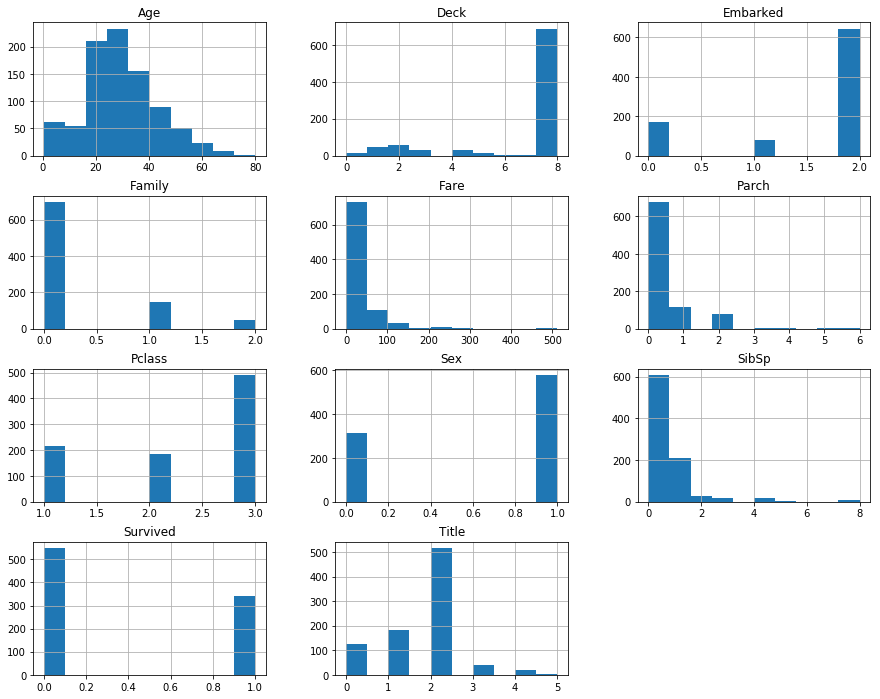

In [33]:
#Convert variables into into to check spread accross categories
#Histograms will give information about how data is spread
train['Sex'] = train['Sex'].astype('int')
train['Family'] = train['Family'].astype('int')
train['Title'] = train['Title'].astype('int')
train['Embarked'] = train['Embarked'].astype('int')
train['Deck'] = train['Deck'].astype('int')
train['Survived'] = train['Survived'].astype('int')
train['Pclass'] = train['Pclass'].astype('int')

train.hist(bins=10,figsize=(15,12), grid=True);

#### Histogram Inference

- _Age_ the histogram shows data are normally distributed, with a single peak.
- _Deck_ is left-skewed, as there are more observations in category 8, this is imputed category.
- _Embarked_, the histogram shows that more passengers boarded from port Southampton, compared to other ports.
- _Family_, the histogram indicates that more passengers were traveling alone.
- _Fare_, the histogram shows that more than three fourth of the passengers paid fare less than \$100.00, few outliers paid fare higher than \$500.00. This makes the graph right-skewed.
- _Pclass_, histogram suggests more passengers were traveling in third class.
- _Sex_, graph suggests there were more male passengers on board.
- _Survived_, suggests that more female passengers survived the tragic Titanic accident.

Following graphs show how each variable is distributed against _Survived_ variable.

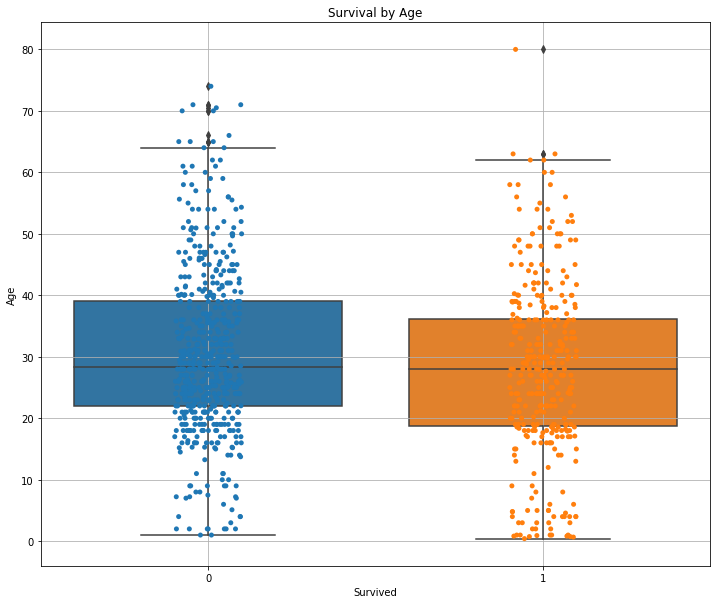

In [34]:
#Convert variables into categories
train['Sex'] = train['Sex'].astype('category')
train['Family'] = train['Family'].astype('category')
train['Title'] = train['Title'].astype('category')
train['Embarked'] = train['Embarked'].astype('category')
train['Deck'] = train['Deck'].astype('category')
train['Survived'] = train['Survived'].astype('category')
train['Pclass'] = train['Pclass'].astype('category')

#Spread between age and survival
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.boxplot(x="Survived", y="Age", data=train)
ax = sns.stripplot(x="Survived", y="Age", data=train, jitter=True, edgecolor="gray")
ax.set_title("Survival by Age", fontsize=12);
plt.grid(True)

Median age of passenger that survived Vs. not is same, little less than 30 years. There are is an outlier in survial category where passenger age is approximately 80 years, yet surived. However, data spread accross age and survival is normally distributed.

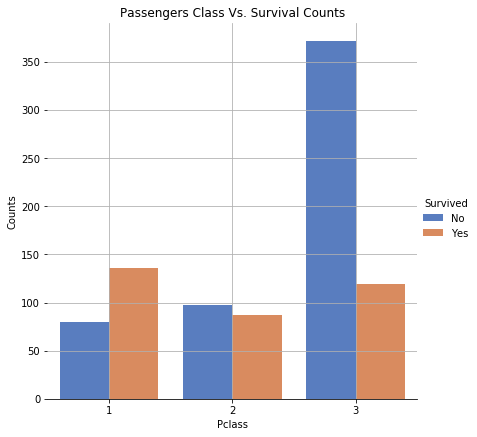

In [35]:
#Spread between passenger class and survival
df = train.groupby(['Pclass', 'Survived']).size().sort_values(ascending=False).reset_index(name='count')
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})

g = sns.catplot(x="Pclass", y="count", hue="Survived", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Passengers Class Vs. Survival Counts", fontsize=12)
plt.grid(True)

In [36]:
df #Spread between passenger class and survival

,Pclass,Survived,count
0,3,No,372
1,1,Yes,136
2,3,Yes,119
3,2,No,97
4,2,Yes,87
5,1,No,80


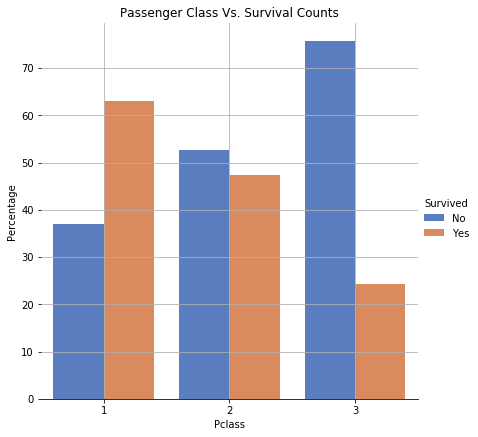

In [37]:
#Calculate percentages
df1 = train.groupby(['Pclass']).size().sort_values(ascending=False).reset_index(name='total')

result = pd.merge(df, df1, on='Pclass', how='inner')
result['Percentage'] = (result['count']*100)/result['total']

g = sns.catplot(x="Pclass", y="Percentage", hue="Survived", data=result,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Percentage")
plt.title("Passenger Class Vs. Survival Counts", fontsize=12)
plt.grid(True)

Data suggests, there is a slightly higher chance of survival if the passenger is from first class, survival chance is almost the same for passengers with a second-class ticket. However, for a passenger with a third-class ticket survival chance is very low. 

It is safe to assume that ticket class profoundly influences passenger survival chances.

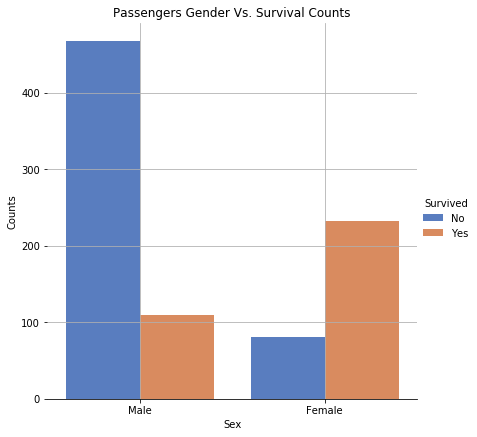

In [38]:
#Spread between gender and survival
df = train.groupby(['Sex', 'Survived']).size().sort_values(ascending=False).reset_index(name='count')
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})
df['Sex'] = df['Sex'].map({0:'Female', 1:'Male'})

g = sns.catplot(x="Sex", y="count", hue="Survived", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Passengers Gender Vs. Survival Counts", fontsize=12);
plt.grid(True)

In [39]:
df #Spread between gender and survival

,Sex,Survived,count
0,Male,No,468
1,Female,Yes,233
2,Male,Yes,109
3,Female,No,81


Data suggests, female passengers have higher chance of survival compared to male passengers.

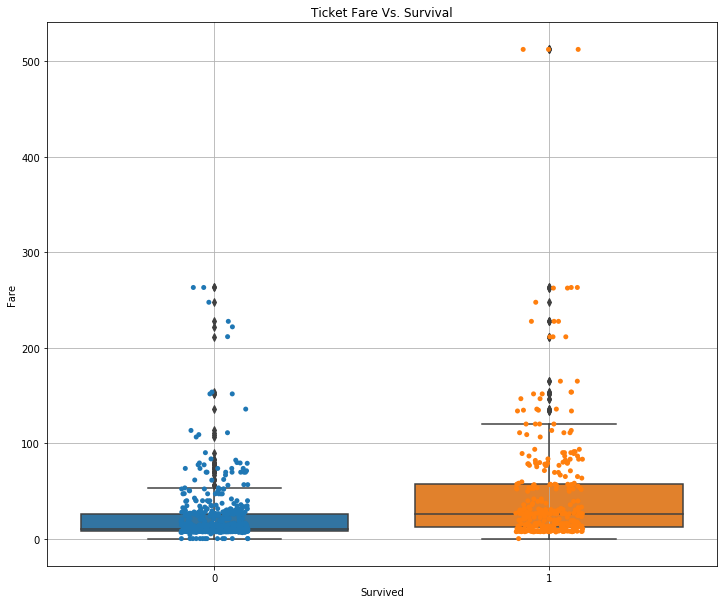

In [40]:
#Spread between ticket fare and survival
fig, ax = plt.subplots(figsize=(12,10))
ax = sns.boxplot(x="Survived", y="Fare", data=train)
ax = sns.stripplot(x="Survived", y="Fare", data=train, jitter=True, edgecolor="gray")
ax.set_title("Ticket Fare Vs. Survival", fontsize=12);
plt.grid(True)

In [41]:
#Passengers paying fare greater than dollars 500
train[train['Fare']>=500].head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck,TicketNumber,Family
258,1,1,0,35.0,0,0,512.3292,0,1,8,17755,0
679,1,1,1,36.0,0,1,512.3292,0,2,1,17755,0
737,1,1,1,35.0,0,0,512.3292,0,2,1,17755,0


Data suggests that there are few outliers in survival class that has paid above \$500 per ticket. However, it would be incorrect assumption that paying higher fare saves lives. It could be a coincidence that passengers booked a first class ticket at the last minute. Overall, data distribution looks normal.

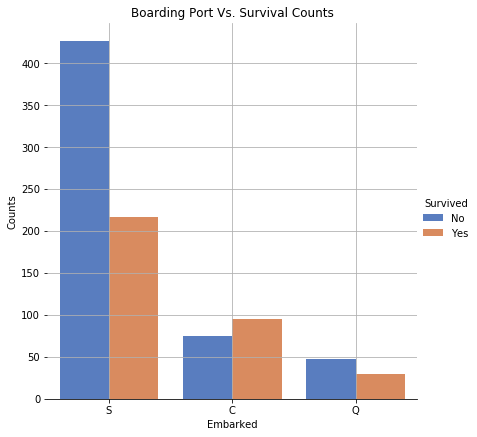

In [42]:
#Spread between embarked and survival
df = train.groupby(['Embarked', 'Survived']).size().sort_values(ascending=False).reset_index(name='count')
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})
df['Embarked'] = df['Embarked'].map({0:'C', 1:'Q', 2:'S'})

g = sns.catplot(x="Embarked", y="count", hue="Survived", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Boarding Port Vs. Survival Counts", fontsize=12)
plt.grid(True)

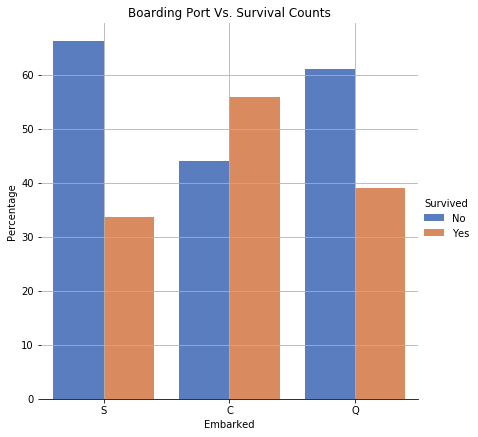

In [43]:
#Calculate percentages
df1 = train.groupby(['Embarked']).size().sort_values(ascending=False).reset_index(name='total')
df1['Embarked'] = df1['Embarked'].map({0:'C', 1:'Q', 2:'S'})

result = pd.merge(df, df1, on='Embarked', how='inner')
result['Percentage'] = (result['count']*100)/result['total']

g = sns.catplot(x="Embarked", y="Percentage", hue="Survived", data=result,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Percentage")
plt.title("Boarding Port Vs. Survival Counts", fontsize=12)
plt.grid(True)

Data suggests, passengers boarding from Southampton port has low survival chance compared to a passenger from other ports. However, it is also true that a high number of passengers boarded from Southhampton port.

When counts are converted into percentages, survival chance is approximately the same for both the Southhampton and Queenstown ports. It is low compared to Cherbourg. On the other hand, the chance of survival vs.not is almost the same for passengers boarding from Cherbourg port.

It is safe to assume that boarding port has no substantial influence on passenger survival.

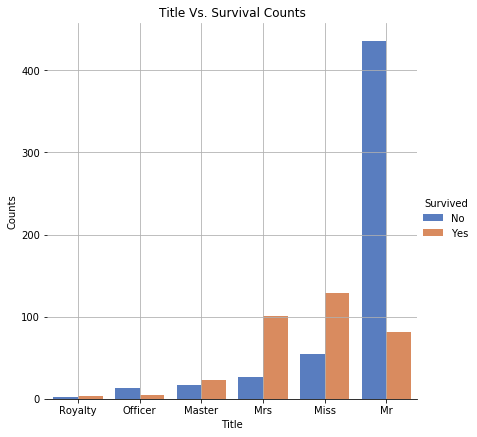

In [44]:
#Spread between title and survival
df = train.groupby(['Title', 'Survived']).size().sort_values(ascending=True).reset_index(name='count')
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})
df['Title'] = df['Title'].map({0:'Mrs', 1:'Miss', 2:'Mr', 3:'Master', 4:'Officer', 5:'Royalty'})

g = sns.catplot(x="Title", y="count", hue="Survived", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Title Vs. Survival Counts", fontsize=12)
plt.grid(True)

Data suggests that female passengers has higher chance of survival.

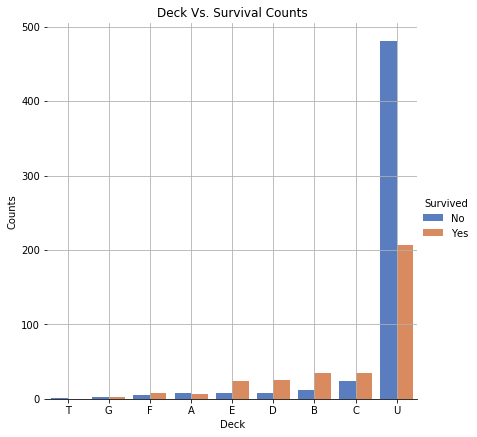

In [45]:
#Spread between Deck and survival
df = train.groupby(['Deck', 'Survived']).size().sort_values(ascending=True).reset_index(name='count')
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})
df['Deck'] = df['Deck'].map({0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'T', 8:'U'})

g = sns.catplot(x="Deck", y="count", hue="Survived", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Deck Vs. Survival Counts", fontsize=12)
plt.grid(True)

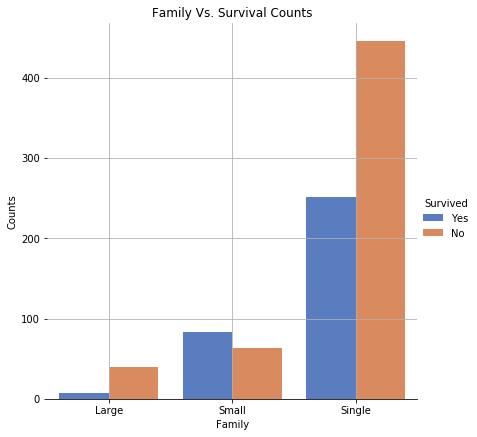

In [46]:
#Spread between Family and survival
df = train.groupby(['Family', 'Survived']).size().sort_values(ascending=True).reset_index(name='count')
df['Survived'] = df['Survived'].map({0:'No', 1:'Yes'})
df['Family'] = df['Family'].map({0:'Single', 1:'Small', 2:'Large'})

g = sns.catplot(x="Family", y="count", hue="Survived", data=df,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Counts")
plt.title("Family Vs. Survival Counts", fontsize=12)
plt.grid(True)

_Deck_ and _Family_ are derived variables. No clear inference can be drawn from these variables other than there were more single passengers on board.

#### Variable Importance To The Model

Using _LogisticRegression_ module let's see importance of variable to the model.

In [47]:
# Create independent variable list
X = train.drop('Survived', axis=1)

# Create dependent variable
y = train['Survived']

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1]


Recursive Feature Elimination(_RFE_) suggests that all variables are contributing to the model in predicting dependent variable _Survived_.

Using _RandomForestRegressor_ module let's see importance of variable to the model.

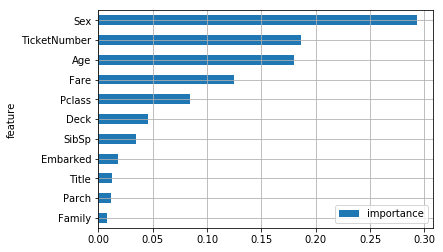

In [48]:
# Create independent variable list
X = train.drop('Survived', axis=1)

# Create dependent variable
y = train['Survived'].astype('int')

# Initiate the model
model = RandomForestRegressor(n_estimators=100, random_state=1, oob_score=True)
model.fit(X, y)

#Get ROC values
roc_auc_score(y, model.oob_prediction_)

#Extract variable importance
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', grid=True)


Above graph suggests that gender of the passenger had higher influence in their survival compared to other variables.

#### Model

Since the dependent variable is binary, it is appropriate to use _Logistic Regression_. I will be using two different methods to build the model using the _sklearn_ library.

#### Logistic Regression



In [49]:
#Building logistic regression
lr_model = LogisticRegression()
lr_model.fit(X, y)

y_pred = lr_model.predict(X)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr_model.score(X, y)))

Accuracy of logistic regression classifier on test set: 0.67


[[499  50]
 [247  95]]


Text(0.5,1,'Confusion Matrix')

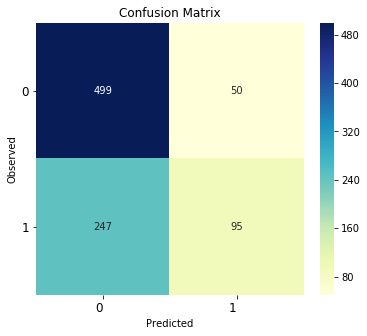

In [50]:
from sklearn.metrics import confusion_matrix as cm
labels = ['Observed', 'Predicted']
cm = cm(y, y_pred)
print(cm)

#Graphical display of confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
fontsize=12
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

Using _Logistic Regression_ module from _sklearn_ library, model predicts 

- 499 passengers did not survive, true positive.
- 247 passengers did not survive, in reality they survived, false positive
- 50 passengers as survived, in reality they did not survive, false negative
- 95 passengers as survived, true negative

Accuracy of the model is 0.67.

In [51]:
#Show precision and f1-score
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.67      0.91      0.77       549
          1       0.66      0.28      0.39       342

avg / total       0.66      0.67      0.62       891



Precision, is the ratio of correctly predicted positive observations to the total predicted positive observations. In our case,

Not Survived(0) = $\frac{TP}{TP+FP} = \frac{499}{499+247} = 0.67$

Survived(1) = $\frac{TN}{TN+FN} = \frac{95}{95+50} = 0.66$

Recall, also known as sensitivity is the ratio of correctly predicted positive observations to the all observations in actual class - yes

Not Survived(0) = $\frac{TP}{TP+FN} = \frac{499}{499+50} = 0.91$

Survived(1) = $\frac{TN}{TN+FP} = \frac{95}{95+247} = 0.28$

F1 Score is the weighted average of Precision and Recall, in other words it _Harmonic mean_ of Precision and Recall

Not Survived(0) = $\frac{2*0.67*0.91}{0.67 + 0.91} = 0.77$

Survived(1) = $\frac{2*0.66*0.28}{0.66 + 0.28} = 0.39$

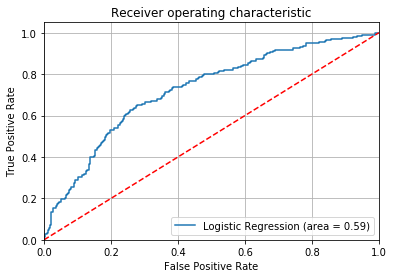

In [52]:
#Draw ROC Curve
logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, lr_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In case of ROC, higher value of area under the curve(AUC) means better model. In our case it 0.59, it means model performs is better than random guess(0.50).

#### Random Forest Regression

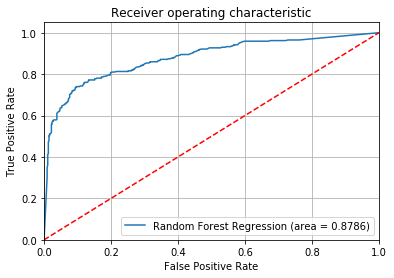

In [53]:
#Define the model and build it,
rf_model = RandomForestRegressor(n_estimators=100, random_state=1, oob_score=True)
rf_model.fit(X, y)
rf_roc_auc = roc_auc_score(y, rf_model.oob_prediction_)

fpr, tpr, thresholds = roc_curve(y, rf_model.oob_prediction_)
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Regression (area = %0.4f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Using n_estimators as 100(trees), the model performs better than _Logistic Regression_ out of the box, AUC is 0.8782. This model can further fine-tuned for various parameters.

Lets fine-tune n_estimators,

/home/data622/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


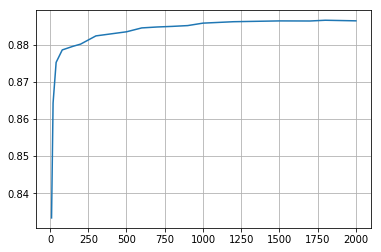

In [54]:
results = []
#List for various options
n_estimators_options = [10, 20, 40, 80, 150, 200, 300, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1700, 1800, 2000]
for trees in n_estimators_options:
    #Build the model
    rf_model = RandomForestRegressor(random_state=1, n_estimators=trees, min_samples_split=2, min_samples_leaf=1, oob_score=True)
    rf_model.fit(X, y)
    
    #Get AUC value
    roc = roc_auc_score(y, rf_model.oob_prediction_)
    
    #Store the output
    results.append(roc)

#Display the graph
pd.Series(results, n_estimators_options).plot(grid=True)

Model stablizes at _n_estimators_ as 1000(trees) and gives better ROC above 0.88. We can further fine-tune min_samples_leaf parameter.

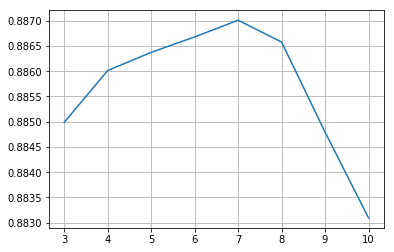

In [55]:
results = []
#Various leaf options
leaf_option = [3, 4, 5, 6, 7, 8, 9, 10]
for leaf in leaf_option:
    #Build the model
    rf_model = RandomForestRegressor(random_state=1, n_estimators=1000, min_samples_split=2, min_samples_leaf=leaf, oob_score=True)
    rf_model.fit(X, y)
    
    #Get AUC
    roc = roc_auc_score(y, rf_model.oob_prediction_)
    
    #Store the results
    results.append(roc)

#Display the graph
pd.Series(results, leaf_option).plot(grid=True)

Model stablizes at min_samples_leaf as 7(leaf) and gives better ROC above 0.88.

In [56]:
#Build new model
rf_model = RandomForestRegressor(random_state=1, n_estimators=1000, min_samples_split=2, min_samples_leaf=7, oob_score=True)
rf_model.fit(X, y)

#Random Forest regression prediction generates probability
pred = pd.DataFrame()
pred['predVal'] = rf_model.oob_prediction_

#Convert 0 and 1
pred['pred'] = pred['predVal'].map(lambda p: 1 if p > 0.5 else 0)
y_pred = pred['pred']

#Generate accuracy of the model
print('Accuracy of Random Forest regression classifier on test set: {:.2f}'.format(rf_model.score(X, y)))

Accuracy of Random Forest regression classifier on test set: 0.65


In [57]:
#Show precision and f1-score
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.83      0.90      0.86       549
          1       0.82      0.70      0.75       342

avg / total       0.82      0.82      0.82       891



[[495  54]
 [104 238]]


Text(0.5,1,'Confusion Matrix')

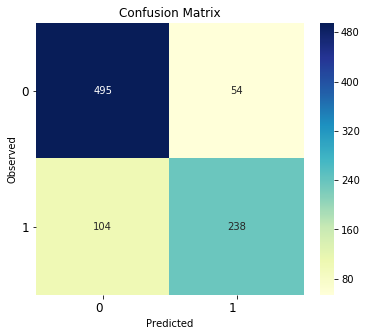

In [58]:
from sklearn.metrics import confusion_matrix as cm

labels = ['Observed', 'Predicted']
cm = cm(y, y_pred)
print(cm)

#Graphical display of confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
fontsize=12
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

Compared to _Logistic Regression_, 

- Accuracy is almost same
- Precision, Recall and f1-score are better
- Confusion matrix, survival is predicted better

Overall Random Forest regression yields a better model than Logistic regression.

#### References
- https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
- https://www.datacamp.com/community/tutorials/categorical-data
- https://www.youtube.com/watch?v=0GrciaGYzV0
- https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
- https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
- https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
- https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d
- https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline/notebook
- http://www.colaberry.com/data-science-predictive-analytics-pipeline/
- http://blog.madhukaraphatak.com/analysing-kaggle-titanic-data/
- http://www.ultravioletanalytics.com/blog/kaggle-titanic-competition-part-iv-derived-variables